# Tour of hera_sim

This notebook briefly introduces some of the effects that can be modeled with `hera_sim`.

In [7]:
%matplotlib inline
import aipy
import uvtools
import numpy as np
import pylab as plt
from hera_sim import DATA_PATH
plt.rcParams["figure.figsize"] = [14, 8]

In [35]:
from hera_sim import foregrounds, noise, sigchain, rfi, defaults

In [38]:
defaults.set("h1c")
fqs = np.linspace(0.1, 0.2, 1024, endpoint=False)
lsts = np.linspace(0, 2 * np.pi, 10000, endpoint=False)
times = lsts / (2 * np.pi) * aipy.const.sidereal_day
bl_len_ns = np.array([30.0, 0, 0])
h1c_beam = defaults("omega_p")(fqs)

## Foregrounds

### Diffuse Foregrounds

In [39]:
Tsky_mdl = noise.HERA_Tsky_mdl["xx"]
vis_fg_diffuse = foregrounds.diffuse_foreground(
    lsts, fqs, bl_len_ns, Tsky_mdl=Tsky_mdl, omega_p=h1c_beam
)

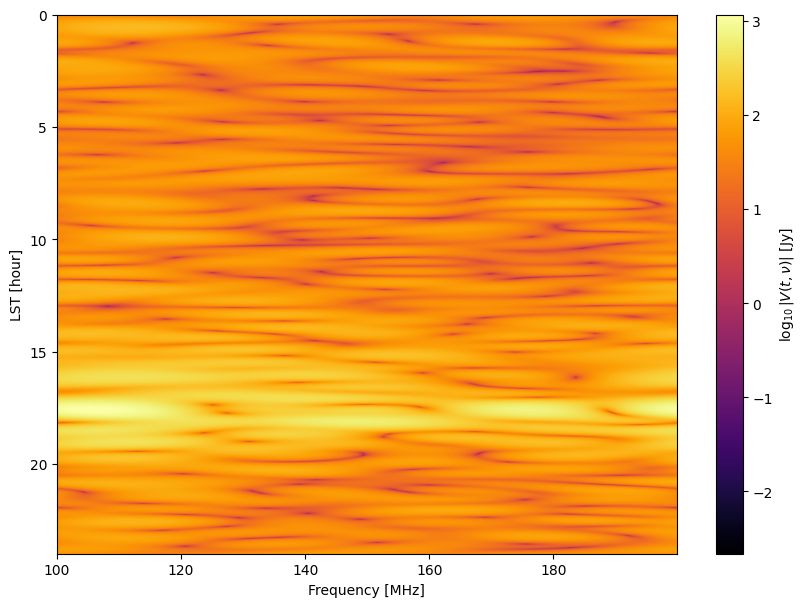

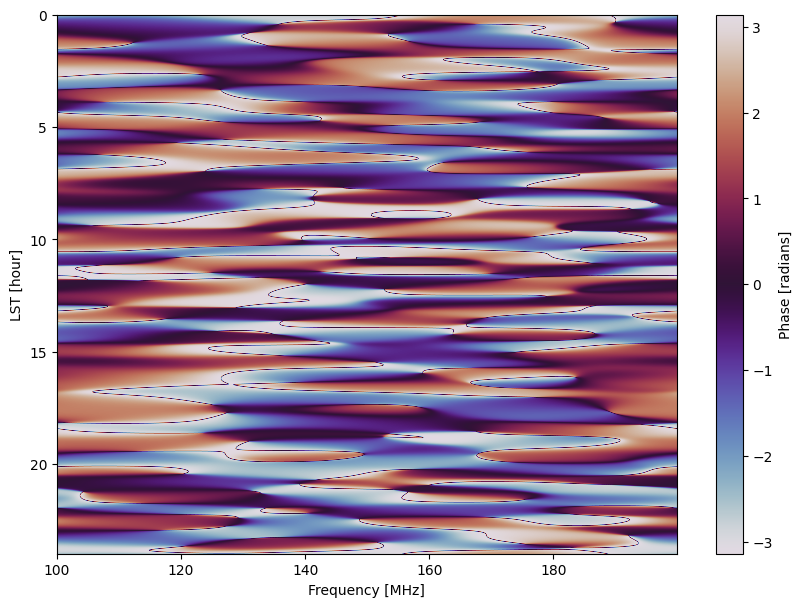

In [73]:
uvtools.plot.labeled_waterfall(vis_fg_diffuse, mode="log", freqs=fqs*1e9, lsts=lsts)
uvtools.plot.labeled_waterfall(vis_fg_diffuse, mode="phs", freqs=fqs*1e9, lsts=lsts);

### Point-Source Foregrounds

In [13]:
vis_fg_pntsrc = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)

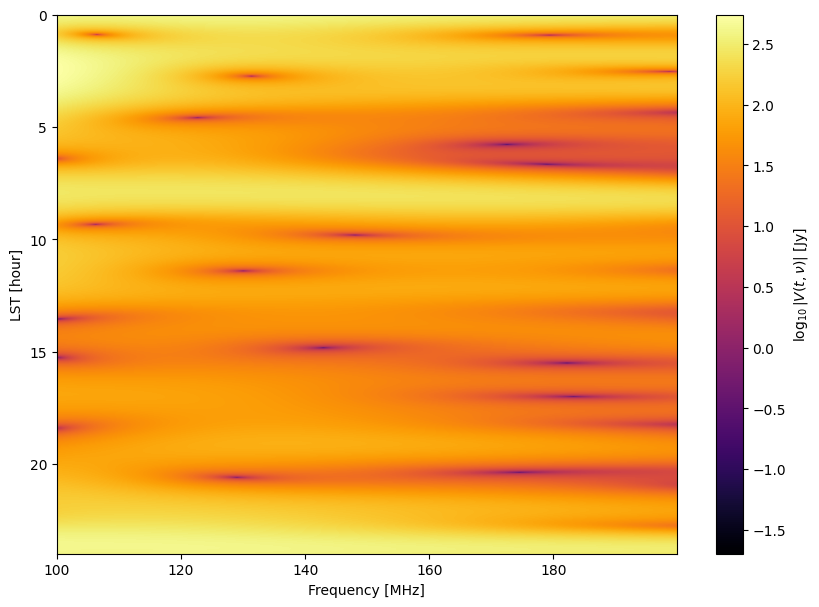

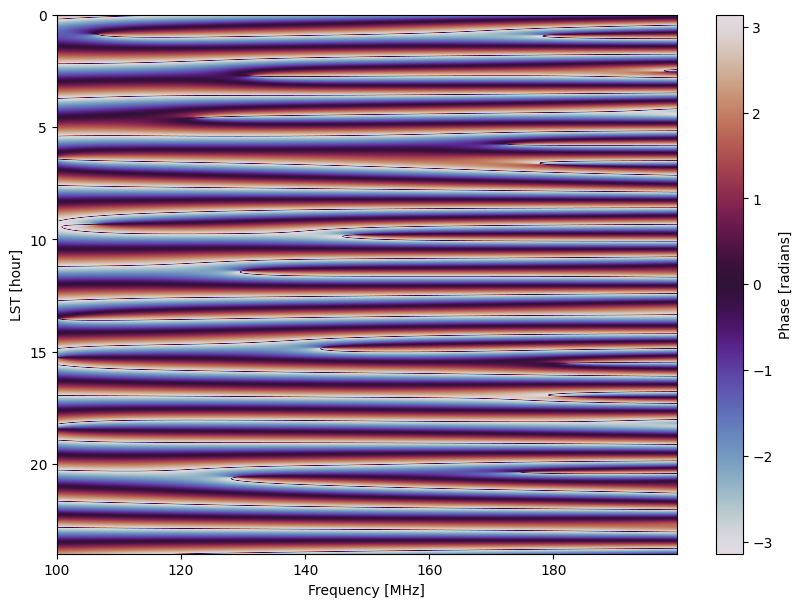

In [55]:
uvtools.plot.labeled_waterfall(vis_fg_pntsrc, mode="log", freqs=fqs*1e9, lsts=lsts)
uvtools.plot.labeled_waterfall(vis_fg_pntsrc, mode="phs", freqs=fqs*1e9, lsts=lsts);

### Diffuse and Point-Source Foregrounds

In [15]:
vis_fg = vis_fg_diffuse + vis_fg_pntsrc

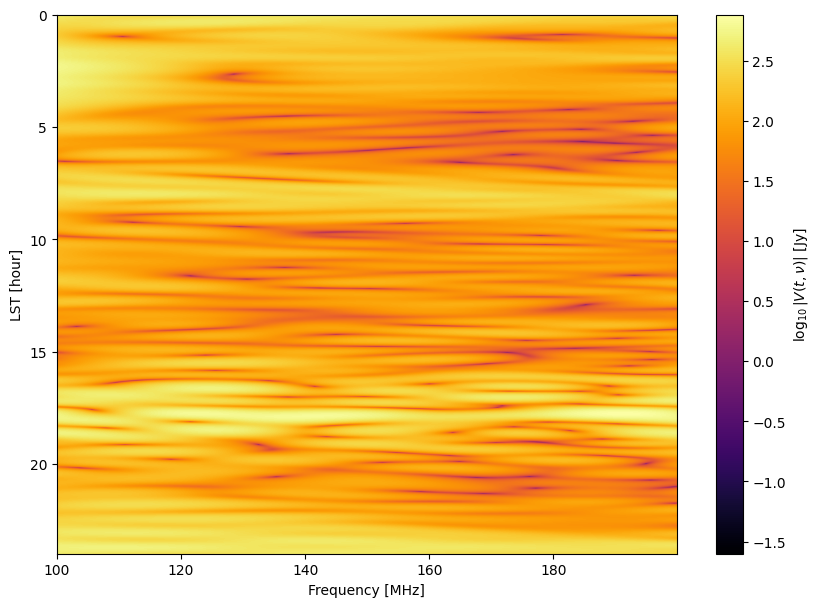

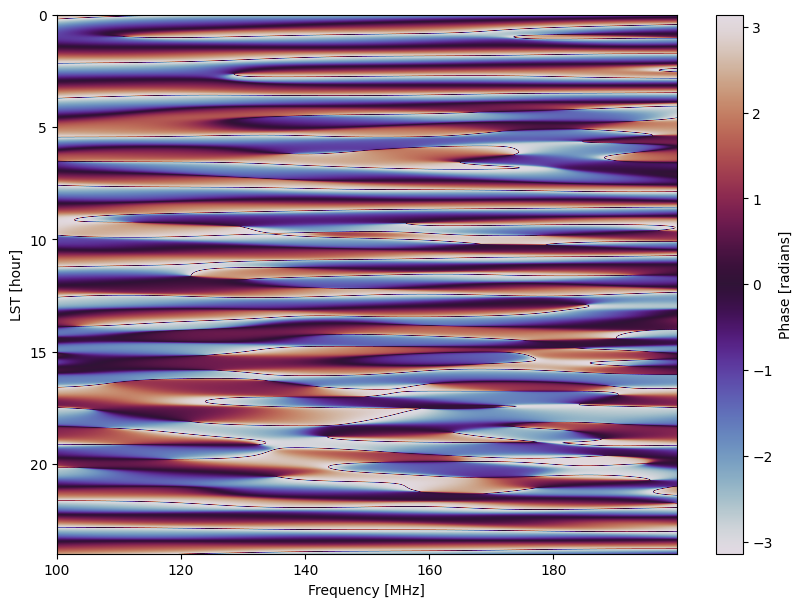

In [56]:
uvtools.plot.labeled_waterfall(vis_fg, mode="log", freqs=fqs*1e9, lsts=lsts)
uvtools.plot.labeled_waterfall(vis_fg, mode="phs", freqs=fqs*1e9, lsts=lsts);

## Noise

In [41]:
nos_jy = noise.sky_noise_jy(
    lsts, fqs, omega_p=h1c_beam, Tsky_mdl=noise.HERA_Tsky_mdl['xx']
)

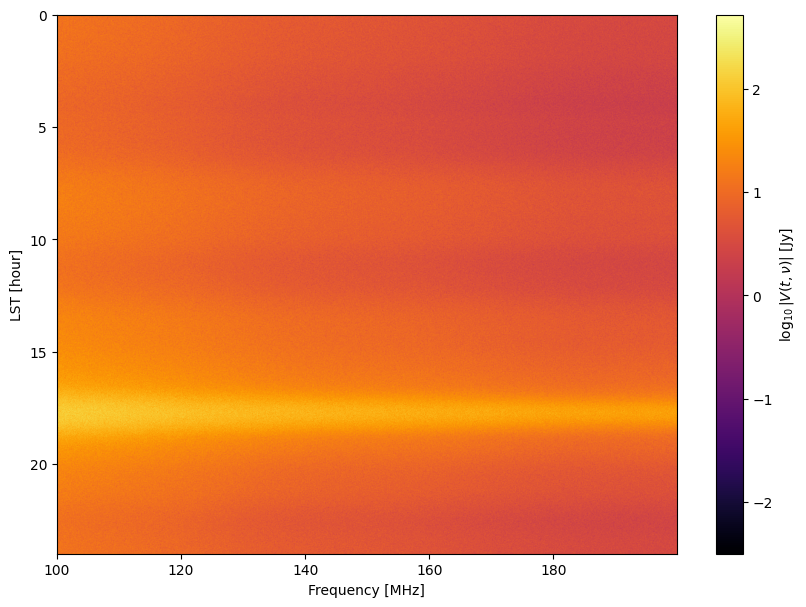

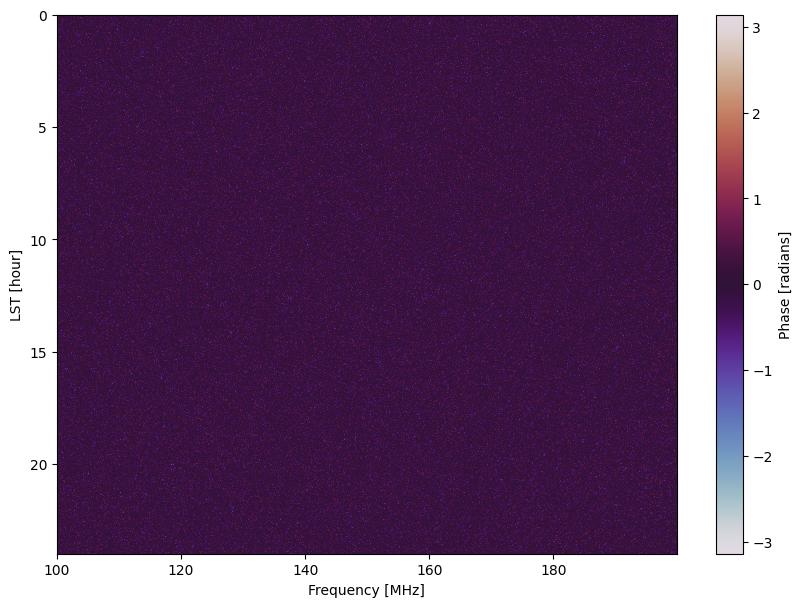

In [57]:
uvtools.plot.labeled_waterfall(nos_jy, mode="log", freqs=fqs*1e9, lsts=lsts)
uvtools.plot.labeled_waterfall(nos_jy, mode="phs", freqs=fqs*1e9, lsts=lsts);

In [43]:
vis_fg_nos = vis_fg + nos_jy

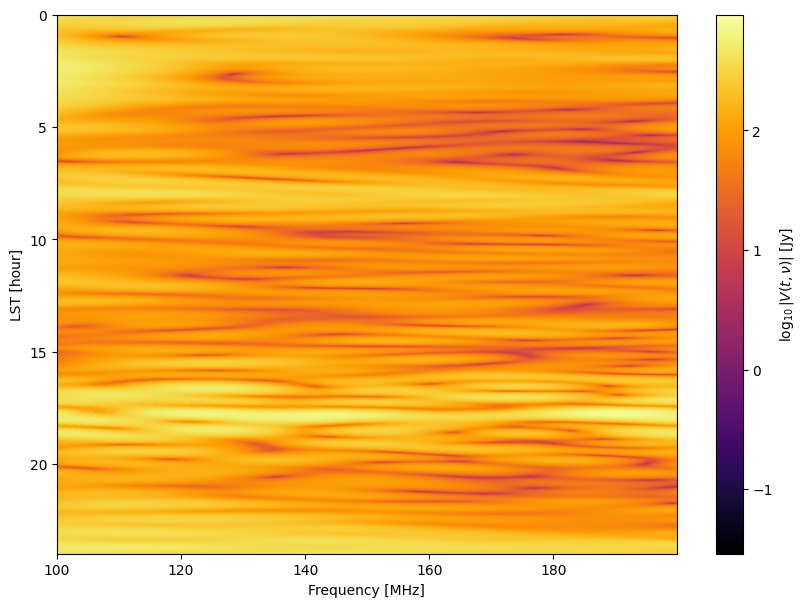

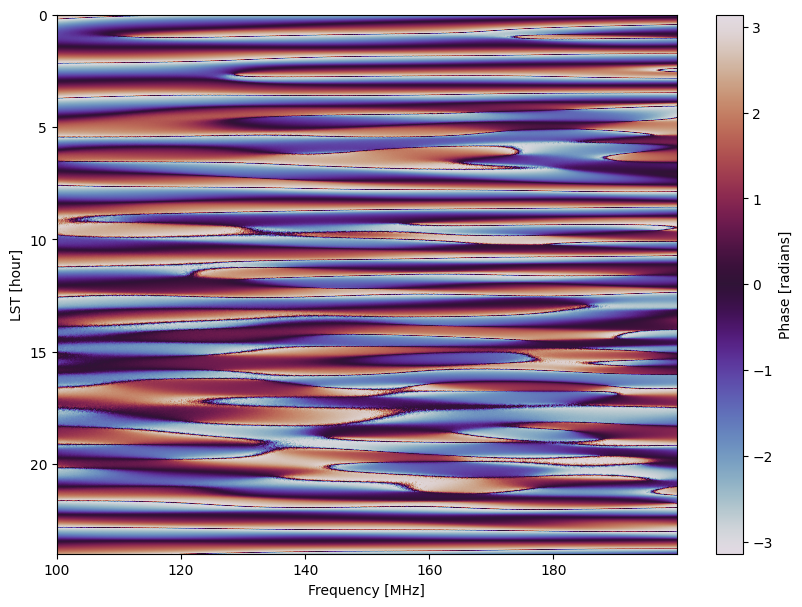

In [58]:
uvtools.plot.labeled_waterfall(vis_fg_nos, mode="log", freqs=fqs*1e9, lsts=lsts)
uvtools.plot.labeled_waterfall(vis_fg_nos, mode="phs", freqs=fqs*1e9, lsts=lsts);

## RFI

In [64]:
rfi1 = rfi.rfi_stations(lsts, fqs, stations=DATA_PATH / "HERA_H1C_RFI_STATIONS.npy")
rfi2 = rfi.rfi_impulse(lsts, fqs, impulse_chance=0.05)
rfi3 = rfi.rfi_scatter(lsts, fqs, scatter_chance=0.01)
rfi_all = rfi1 + rfi2 + rfi3

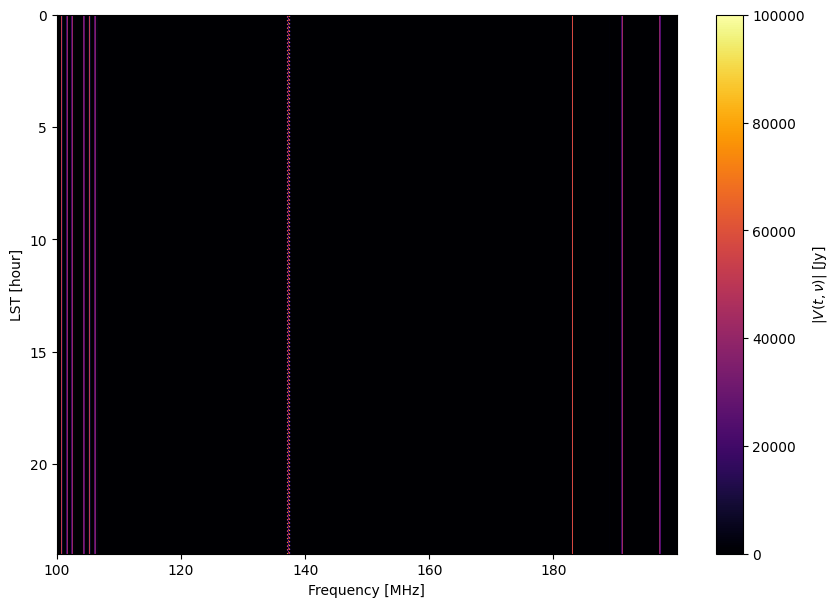

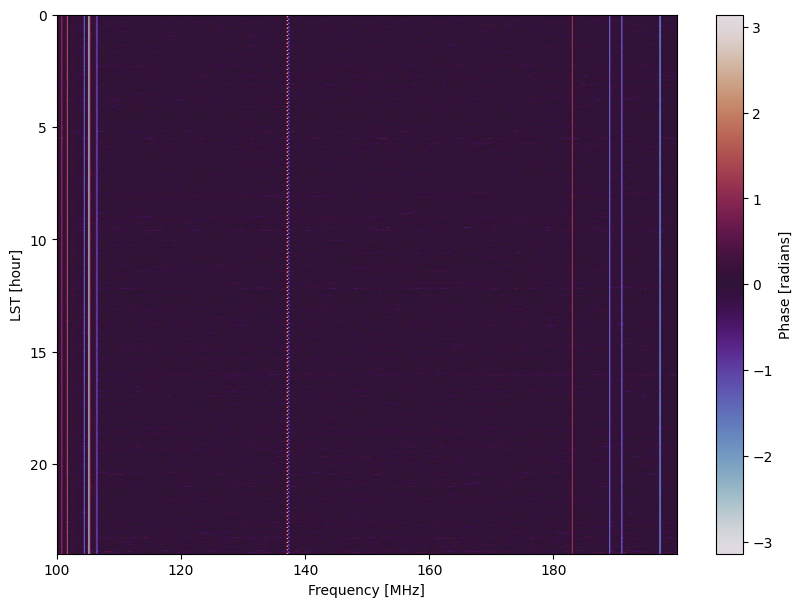

In [66]:
uvtools.plot.labeled_waterfall(rfi_all, mode="abs", freqs=fqs*1e9, lsts=lsts)
uvtools.plot.labeled_waterfall(rfi_all, mode="phs", freqs=fqs*1e9, lsts=lsts);

In [67]:
vis_fg_nos_rfi = vis_fg_nos + rfi_all

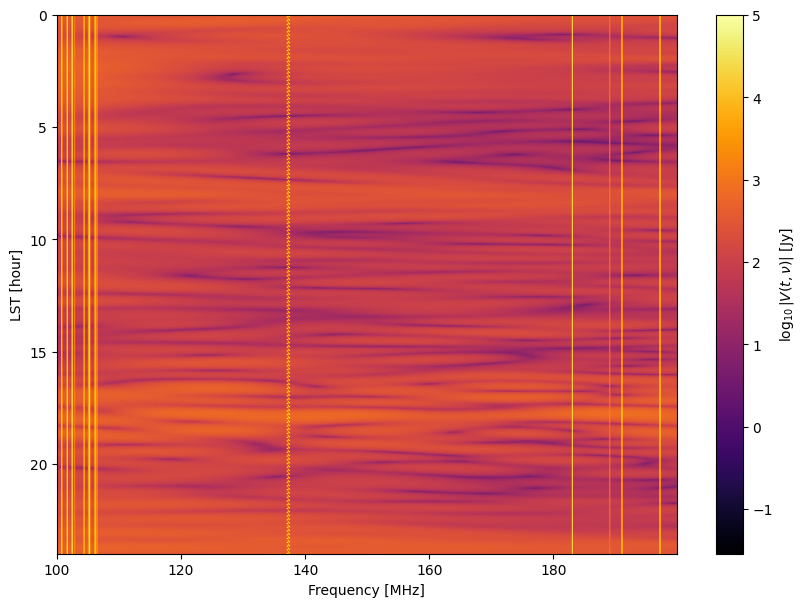

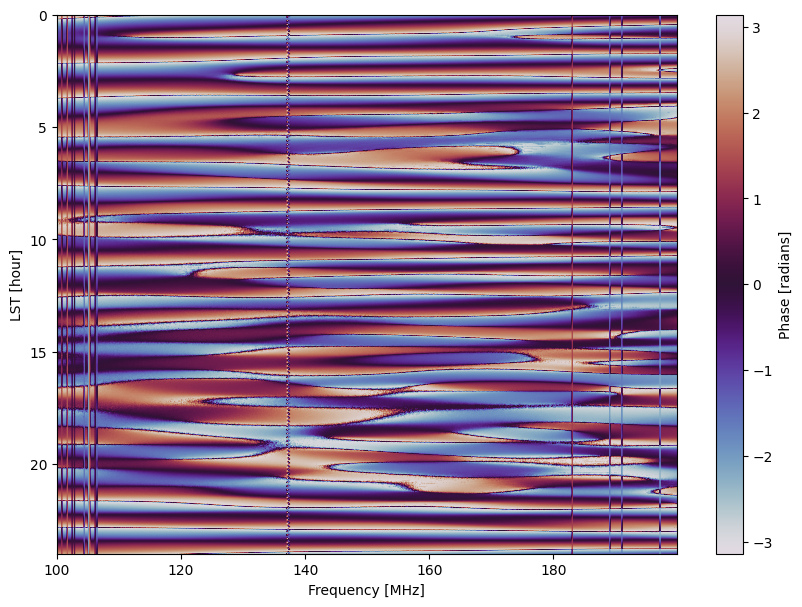

In [68]:
uvtools.plot.labeled_waterfall(vis_fg_nos_rfi, mode="log", freqs=fqs*1e9, lsts=lsts)
uvtools.plot.labeled_waterfall(vis_fg_nos_rfi, mode="phs", freqs=fqs*1e9, lsts=lsts);

## Gains

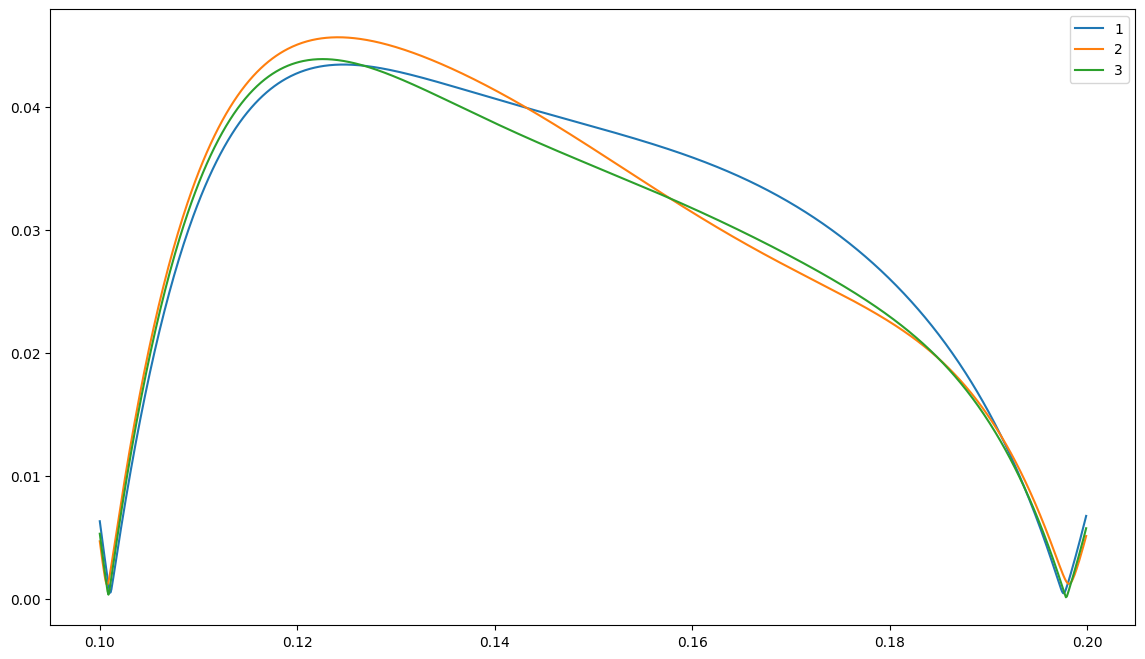

In [69]:
g = sigchain.gen_gains(fqs, [1, 2, 3])
plt.figure()
for i in g:
    plt.plot(fqs, np.abs(g[i]), label=str(i))
plt.legend()
plt.show()
gainscale = np.average([np.median(np.abs(g[i])) for i in g])
MXG = MX + np.log10(gainscale)

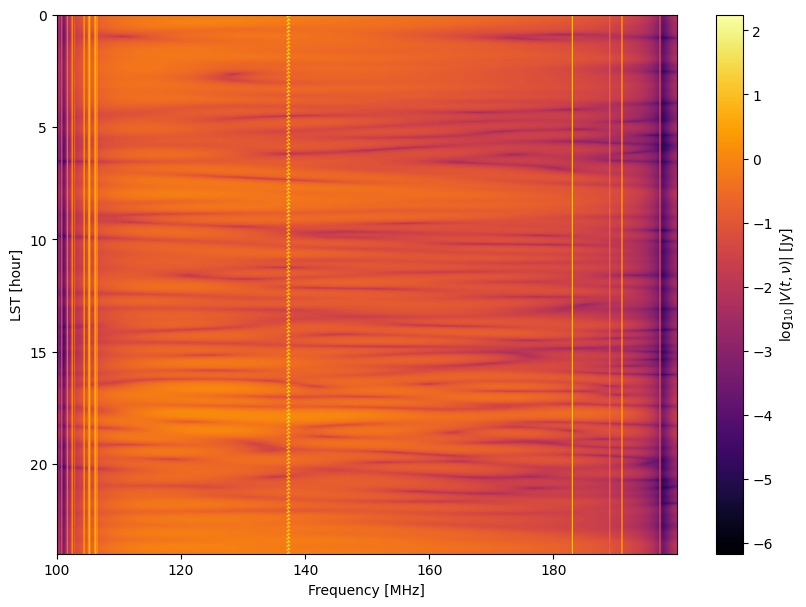

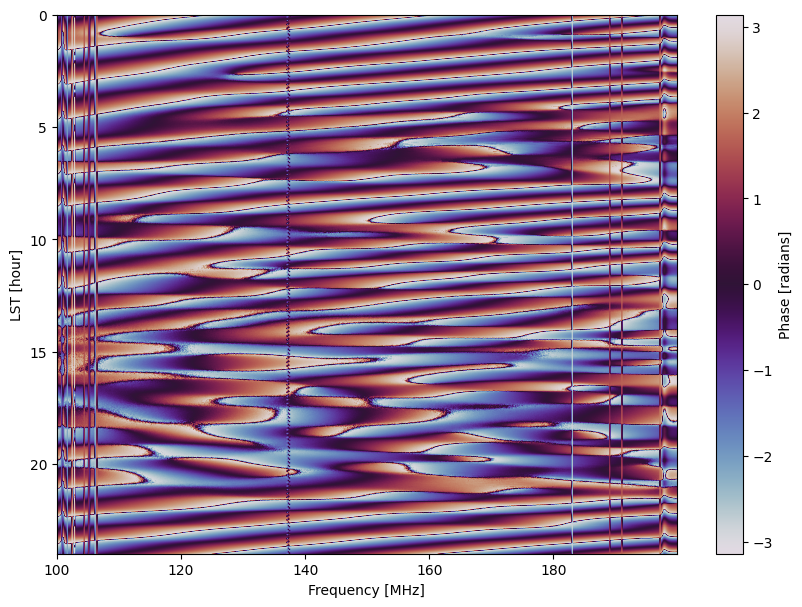

In [70]:
vis_total = sigchain.apply_gains(vis_fg_nos_rfi, g, (1, 2))

uvtools.plot.labeled_waterfall(vis_total, mode="log", freqs=fqs*1e9, lsts=lsts)
uvtools.plot.labeled_waterfall(vis_total, mode="phs", freqs=fqs*1e9, lsts=lsts);

## Crosstalk

In [71]:
xtalk = sigchain.gen_whitenoise_xtalk(fqs)
if xtalk.ndim == 1:
    xtalk = np.reshape(xtalk, (1, -1))
vis_xtalk = vis_fg_nos_rfi + xtalk
vis_xtalk = sigchain.apply_gains(vis_xtalk, g, (1, 2))

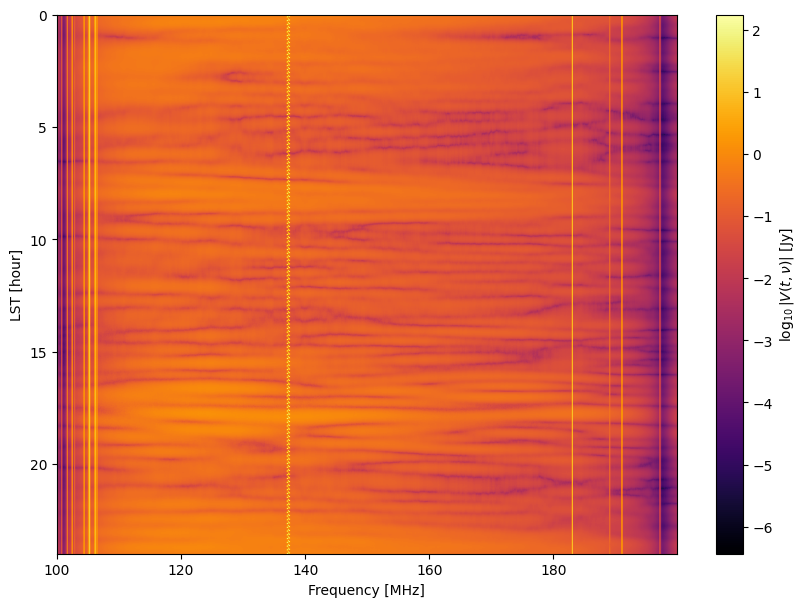

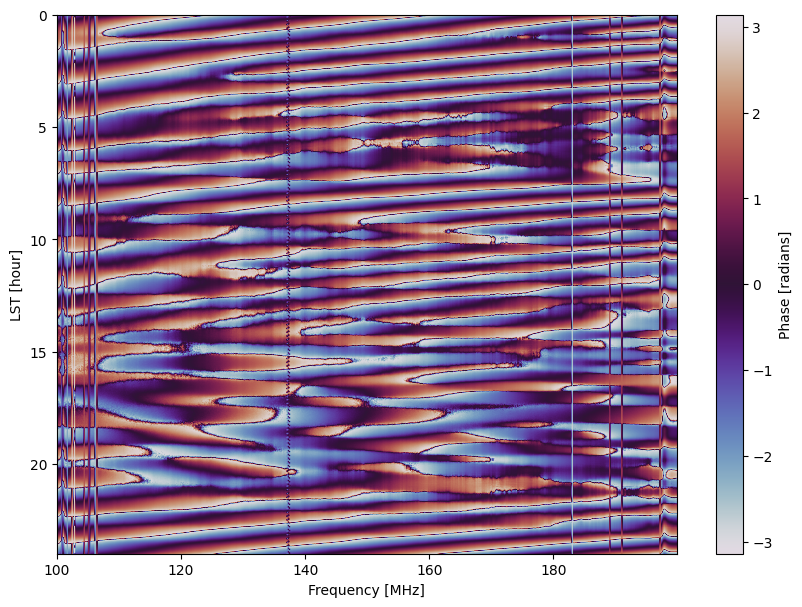

In [72]:
uvtools.plot.labeled_waterfall(vis_xtalk, mode="log", freqs=fqs*1e9, lsts=lsts)
uvtools.plot.labeled_waterfall(vis_xtalk, mode="phs", freqs=fqs*1e9, lsts=lsts);